#**ECE 4554 / ECE 5554 / Computer Vision**
This file contains the coding problems for Homework 3. Please implement/modify the sections within this notebook that are marked "TO DO".

**Problems 4 and 5 are required for all students.
Problem 6 is required for 5554 students, but is optional for 4554 students**

##**TO DO**: Enter your Virginia Tech Username (PID) here: _______ddave_____________
(Your Username is usually part of your email address, as in Username@vt.edu.)

##**Honor Code reminder**

Please review the Honor Code statement in the syllabus.  This is not a "team project". If you obtained code or were inspired by code from any source except the instructor, you must cite those sources using comment lines in your solution.  

##**Code libraries**
You are allowed to use NumPy and Matplotlib functions to perform matrix operations and graphics/plotting operations. You are  allowed to use OpenCV functions for graphics/plotting, such as `cv2.circle` and `cv2.line`. You are also allowed to use any OpenCV functions that are provided in this start-up notebook, but do not use any other OpenCV functions without permission from the instructor.

##**Submission guidelines** for the coding problems (Google Colab)

1. Please verify that you have entered your Virginia Tech Username in all of the appropriate places.
2. After clicking Runtime->Run all, verify that all of your solutions are visible in this notebook.
3. Click File->Save near the top of the page to save the latest version of your notebook at Google Drive.
4. Verify that the last 2 cells have executed, creating a PDF version of this notebook at Google Drive. (Note: if you face difficulty with this step, please refer to https://pypi.org/project/notebook-as-pdf/)
5. Look at the PDF file and check that all of your solutions are displayed correctly there.
6. Download your notebook file and the PDF version to your laptop.
7. On your laptop, create a ZIP version of this notebook file. (Please don't include the separate data files.) Use file name Homework3_Code_USERNAME.zip, with your own Username.
6. For your PDF version, use file name Homework3_Notebook_USERNAME.pdf, with your own Username.
7. **Submit these 2 files and your PDF file for Problems 1-3 SEPARATELY to Canvas.** Do not zip them all together.

##**Overview**

For Problem 4,
you must write code that can solve for a *2D homography* using 2D point correspondences. You must also write code to perform image warping using your 2D homography solution.

For problem 5,
you must write code to find the *fundamental matrix* for a stereo image pair. You  also need to write code to display keypoints and epipolar lines in the two images. For this problem, you may assume that no outliers are present in your set of corresponding image points.

For Problem 6,
you will extend the previous problem by using RANSAC to address the problem of outliers.


# **Environment setup**

In [ ]:
# Mount your Google Drive to this notebook
# The purpose is to allow your code to access to your files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [213]:
# Change the directory to your own working directory
# Any files under your working directory are available to your code
# TO DO: enter the name of your directory
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/HW3')


In [214]:
# Import library modules
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import optimize
from PIL import Image  # Python Imaging Library
# The following is a substitute for cv2.imshow,
#  which you would use on your local machine but Colab does not support it
from google.colab.patches import cv2_imshow

print('Python version:', sys.version)
print('OpenCV version:', cv2.__version__)
print('NumPy version: ', np.__version__)


Python version: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
OpenCV version: 4.10.0
NumPy version:  1.26.4


#**Getting started**

Several image files were provided to you (including `mandrill.tif`, etc.). Upload all of those image files to your working directory.

The following functions are helpful for loading images into floating-point format, and for displaying images that are in that format.  Let's use those functions to display an example image.

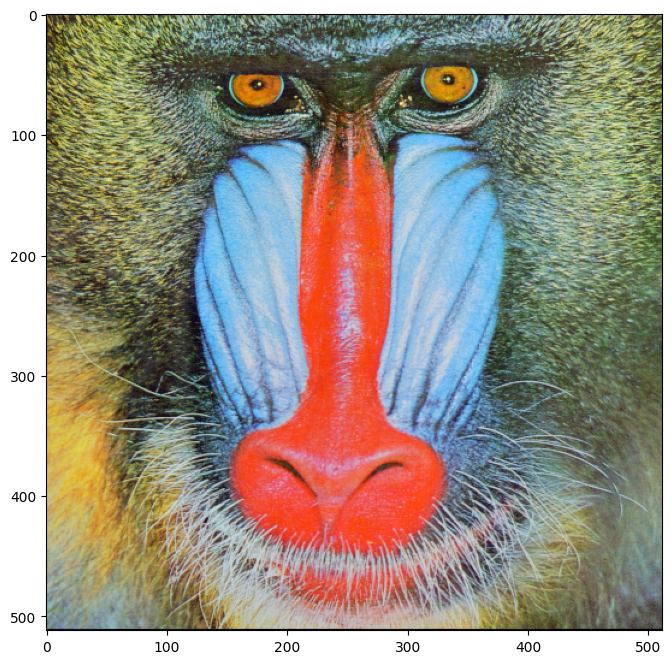

In [215]:
def load_image(filename):
  img = np.asarray(Image.open(filename))
  img = img.astype("float32")/255.0
  return img

def show_image(img):
  fig = plt.figure()
  fig.set_size_inches(10, 8) # You can adjust the size of the displayed figure
  plt.imshow(img)

mandrill_img = load_image("mandrill.tif")
show_image(mandrill_img)


#**Problem 4: Image warping**

**Part (a):  2D homography**

Implement the 2 functions that are shown in the next code block. (OpenCV has a findHomography() function and other related functions, but for this assignment you must write your own versions.)

1.   **compute_homography(src, dst)** receives two matrices, each of size Nx2. Each matrix contains N two-dimensional points. For each value of i, src[i] and dst[i] are corresponding points from two different images. The function should return the homography matrix H of size 3x3 that maps every point from the source (src) to the destination (dst).   *Guidance*: You may assume that N is at least 4. You can set up the problem in a matrix-based, least-squares format. (A somewhat similar problem is in the lecture slides on page 16 of packet 15.) Helpful functions are `np.linalg.eig()` and `np.linalg.eigh()` for computing eigenvalues and eigenvectors. The latter function will prevent warnings due to small imaginary values if you are working with matrices that are real and symmetric.
2.   **apply_homography(src, H)** receives points in matrix src (an Nx2 matrix), and a homography transformation H (a 3x3 matrix). This function should use the homography matrix to transform each point in src to a new destination point. Store the resulting points in matrix dst, which is the same size as src. The function should return dst. *Guidance*: Remember to use homogeneous coordinates when implementing this transformation.

In [216]:
def compute_homography(src, dst):
    '''Computes the homography matrix from src to dst.
     Input:
      src: source points, shape (N, 2), where N = 4
      dst: destination points, shape (N, 2)
     Output:
      H: homography matrix, shape (3, 3)
    '''
    N = src.shape[0]
    A = []

    for i in range(N):
        x, y = src[i, 0], src[i, 1]
        u, v = dst[i, 0], dst[i, 1]
        A.append([x, y, 1, 0, 0, 0, -u * x, -u * y, -u])
        A.append([0, 0, 0, x, y, 1, -v * x, -v * y, -v])

    A = np.array(A)
    U, S, V = np.linalg.svd(A)
    H = V[-1].reshape(3, 3)

    # Normalize so that H[2, 2] is 1
    # H /= H[2, 2]

    return H

def apply_homography(src, H):
    '''Applies a homography H to the source points.
     Input:
        src: source points, shape (N, 2)
        H: homography from source points to destination points, shape (3, 3)
     Output:
       dst: destination points, shape (N, 2)
    '''
    # Convert inputs to arrays
    src = np.asarray(src)
    H = np.asarray(H)

    N = src.shape[0]
    src_homogeneous = np.hstack([src, np.ones((N, 1))])  # Convert to homogeneous coordinates
    dst_homogeneous = H @ src_homogeneous.T  # Apply homography
    dst_homogeneous = dst_homogeneous.T

    # Convert back to Cartesian coordinates
    dst = dst_homogeneous[:, :2] / dst_homogeneous[:, 2][:, np.newaxis]

    # Convert dst back to np.matrix for compatibility
    # dst = np.asmatrix(dst)

    return dst


Use the following code block to test your homography code. Some example corresponding points are provided to you in src_pts and dst_pts. If your implementation is correct, it should map the points given in test_pts to locations that are close to the points given in match_pts_correct. If you have correctly implemented compute_homography() and apply_homography(), then the printed difference values should be close to 0. (A small difference, such as 0.001, should be acceptable.)


In [217]:
# Do not modify this code block. If you would like to edit this code
#  for debugging purposes, copy it into a separate code block and edit that copy.
def test_homography():
  src_pts = np.matrix('0, 0; 1, 0; 1, 1; 0, 1')
  dst_pts = np.matrix('5, 4; 7, 4; 7, 5; 6, 6')
  H = compute_homography(src_pts, dst_pts)
  test_pts = np.matrix('0,  0; 1, 0; 1, 1; 0, 1')
  match_pts = apply_homography(test_pts, H)
  match_pts_correct = np.matrix('5, 4; 7, 4; 7, 5; 6, 6')
  print('Your 1st solution differs from our solution by: %f'
    % np.square(match_pts - match_pts_correct).sum())

  src_pts = np.matrix('0, 0; 1, 0; 1, 1; 0, 1; 2, 3')
  dst_pts = np.matrix('5, 4; 7, 4; 7, 5; 6, 6; 7.25, 5.5')
  H = compute_homography(src_pts, dst_pts)
  test_pts = np.matrix('0,  0; 1, 0; 1, 1; 0, 1')
  match_pts = apply_homography(test_pts, H)
  match_pts_correct = np.matrix('5, 4; 7, 4; 7, 5; 6, 6')
  print('Your 2nd solution differs from our solution by: %f'
    % np.square(match_pts - match_pts_correct).sum())

  src_pts = np.matrix('347, 313; 502, 341; 386, 571; 621, 508')
  dst_pts = np.matrix('274, 286; 436, 305; 305, 527; 615, 506')
  H = compute_homography(src_pts, dst_pts)
  test_pts = np.matrix('259, 505; 350, 371; 400, 675; 636, 104')
  match_pts = apply_homography(test_pts, H)
  match_pts_correct = np.matrix('195.13761083, 448.12645033;'
    '275.27269386, 336.54819916;'
    '317.37663747, 636.78403426;'
    '618.50438823, 28.78963905')
  print('Your 3rd solution differs from our solution by: %f'
    % np.square(match_pts - match_pts_correct).sum())

test_homography()


Your 1st solution differs from our solution by: 0.000000
Your 2nd solution differs from our solution by: 0.000000
Your 3rd solution differs from our solution by: 0.000000


**Part (b):  Image warping using a 2D homography**

Implement the following function so that it performs image warping from a source image (`src_img`) to a newly created destination image (`dst_img`). Do not use any additional OpenCV functions. The homography H that is provided indicates a desired mapping from `src_img` to `dst_img`.

*Guidance:*  To prevent gaps in your output image, it is suggested that your implementation should iterate over all pixels in `dst_img`. In that case, your code should use the *inverse* of H to find values in `src_img` as it iterates over `dst_img`.


In [218]:
def warp_img(src_img, H, dst_img_size):
    '''Warping of a source image using a homography.
     Input:
        src_img: source image with shape (m, n, 3)
        H: homography matrix, shape (3, 3), from source image to destination image
        dst_img_size: height and width of destination image; shape (2,)
     Output:
        dst_img: destination image; height and width specified by dst_img_size parameter
    '''
    dst_img = np.zeros([dst_img_size[0], dst_img_size[1], src_img.shape[2]])
    H_inv = np.linalg.inv(H)

    for x_dst in range(dst_img_size[0]):
        for y_dst in range(dst_img_size[1]):
          dst_coordinates = np.array([x_dst, y_dst, 1])
          src_coordinates = H_inv @ dst_coordinates
          # src_coordinates = src_coordinates / src_coordinates[2]
          x_src = int(src_coordinates[0]/src_coordinates[2])
          y_src = int(src_coordinates[1]/src_coordinates[2])
          if 0<=x_src<src_img.shape[0] and 0<=y_src<src_img.shape[1]:
            dst_img[x_dst, y_dst] = src_img[int(x_src), int(y_src)]
    return dst_img

The following will test your image_warp function by performing a 2D rotation. You do not need to change any code in the following block. If your code is correct, the output here should show a mandrill image that has been rotated by 10 degrees counterclockwise about the upper-left corner.


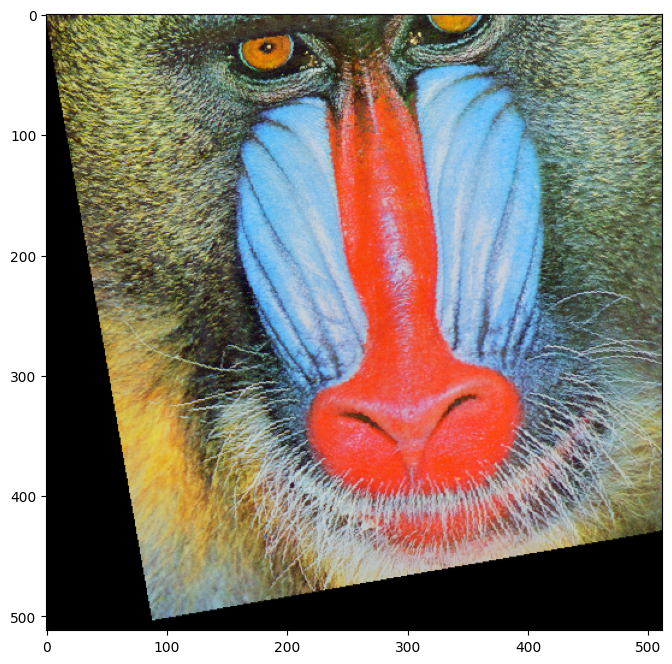

In [219]:
# Do not modify this code block. If you would like to edit this code
#  for debugging purposes, copy it into a separate code block and edit that copy.
def test_rotation():
  src_img = load_image('mandrill.tif')
  canvas_img = np.zeros([src_img.shape[0], src_img.shape[1], 3])

  theta = 10  # counterclockwise rotation angle in degrees
  H = [[np.cos(theta * np.pi/180), -np.sin(theta * np.pi/180), 0.0],
       [np.sin(theta * np.pi/180), np.cos(theta * np.pi/180), 0.0],
       [0.0, 0.0, 1.0]]

  dst_img = warp_img(src_img, H, [canvas_img.shape[0], canvas_img.shape[1]])
  show_image(dst_img)

test_rotation()


The following will test your image_warp function with a more general homography. You do not need to modify these functions. If your code is correct, the output here should show a  mandrill image that has been warped to overlay the blue side of a Rubik's cube.


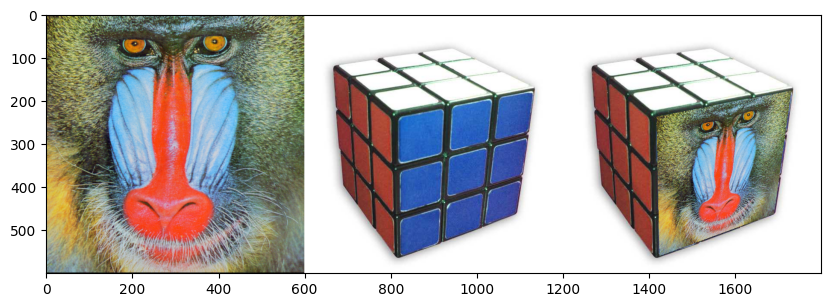

In [220]:
# Do not modify this code block. If you would like to edit this code
#  for debugging purposes, copy it into a separate code block and edit that copy.
def binary_mask(img):
  '''Create a binary mask of the image content.
   Input:
    img: source image, shape (m, n, 3)
   Output:
    mask: image of shape (m, n) and type 'int'. For pixel [i, j] of mask,
      if pixel [i, j] in img is nonzero in any channel, assign 1 to mask[i, j].
      Else, assign 0 to mask[i, j].
  '''
  mask = (img[:, :, 0] > 0) | (img[:, :, 1] > 0) | (img[:, :, 2] > 0)
  mask = mask.astype("int")
  return mask

def test_warp():
  src_img = load_image('mandrill.tif')
  canvas_img = load_image('Rubiks_cube.jpg')

  # The following are corners of the mandrill image in (ROW, COLUMN) order
  src_pts = np.matrix('0, 0; 511, 0; 511, 511; 0, 511')
  # The following are corners of the blue face of the Rubik's cube
  canvas_pts = np.matrix('238, 218; 560, 225; 463, 490; 178, 530')

  # The following was used during debugging
  # The center of the circle is specified using (COLUMN, ROW) coordinates
  # cv2.circle(canvas_img, (218, 238), 4, (255, 0, 0), thickness=10)

  H = compute_homography(src_pts, canvas_pts)
  dst_img = warp_img(src_img, H, [canvas_img.shape[0], canvas_img.shape[1]])
  dst_mask = 1 - binary_mask(dst_img)
  dst_mask = np.stack((dst_mask,) * 3, -1)
  out_img = np.multiply(canvas_img, dst_mask) + dst_img

  dsize = (600, 600) # width and height of canvas_im
  src_smaller = cv2.resize(src_img, dsize, interpolation=cv2.INTER_AREA)

  warped_img = np.concatenate((src_smaller, canvas_img, out_img), axis=1)
  show_image(np.clip(warped_img, 0, 1))

test_warp()


Next, you must demonstrate your image warping code by mapping a desert image onto a billboard. You have been given two images, `billboard.png` and `desert.png`.  In the code block below, write code that places an appropriately reshaped (warped) version of `desert.png` into the white billboard region within  `billboard.png`. Your solution must utilize your functions `compute_homography()` and `apply_homography()`, and must display the billboard image before and after it is modified.

*Guidance*: Your code does not need to locate the billboard automatically. It is suggested that you find the coordinates of the billboard's 4 corners manually, and then hard-code those coordinates into your solution. Use those coordinates to solve for the appropriate homography and perform the image mapping step.

(Credit to the following web sites for billboard and desert images: https://mediavenue.com and https://EgyptTravelBlog.com.)

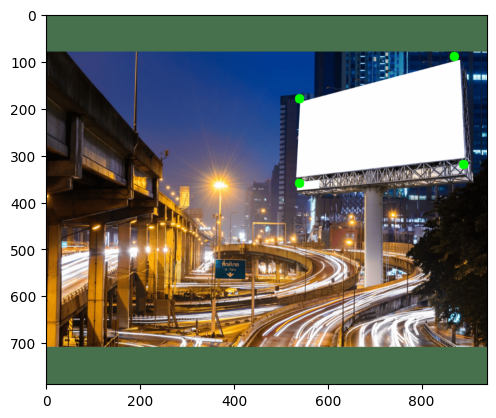

Updated corners of the billboard: [[540. 360.]
 [540. 180.]
 [890. 320.]
 [870.  90.]]


In [221]:
def load_image(filename):
    return cv2.imread(filename)

def display_image_with_points(image):
    # Function to display the image to manually note down the billboard corners
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('on')  # Show axes to help with identifying coordinates
    plt.show()

# Load the image
billboard_img = load_image('billboard.png')

# Use the manually provided coordinates for the billboard corners
billboard_corners = np.array([
    [540, 360],  # bottom-left corner
    [540, 180],  # Top-left corner
    [890, 320],  # Bottom-right corner
    [870, 90]    # top-lright corner
], dtype=np.float32)

# Display the corners on the image for verification
def display_image_with_corners(image, corners):
    image_with_corners = image.copy()
    for corner in corners:
        # Convert corner coordinates to integers
        corner = tuple(map(int, corner))
        cv2.circle(image_with_corners, corner, 10, (0, 255, 0), -1)

    plt.imshow(cv2.cvtColor(image_with_corners, cv2.COLOR_BGR2RGB))
    plt.axis('on')
    plt.show()

# Verify the manually identified corners
display_image_with_corners(billboard_img, billboard_corners)

print("Updated corners of the billboard:", billboard_corners)


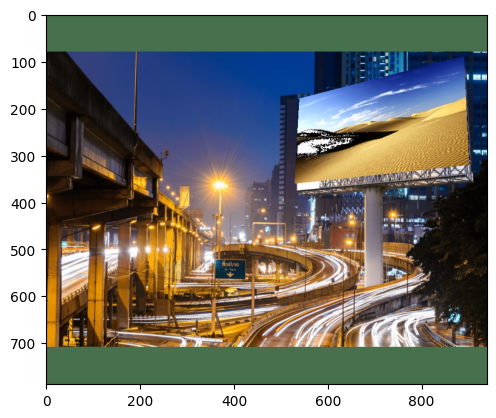

In [224]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def load_image(filename):
    '''Loads an image from a file and converts it to RGB format.'''
    img = cv2.imread(filename)
    if img is None:
        raise FileNotFoundError(f"Image file '{filename}' not found.")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def binary_mask(img):
    '''Create a binary mask of the image content.'''
    mask = (img[:, :, 0] > 0) | (img[:, :, 1] > 0) | (img[:, :, 2] > 0)
    return mask.astype(int)

def show_image(img):
    '''Displays an image using Matplotlib.'''
    plt.imshow(img)
    plt.axis('on')
    plt.show()

def warp_img(src_img, H, dst_img_size):
    '''Warping of a source image using a homography.
     Input:
        src_img: source image with shape (m, n, 3)
        H: homography matrix, shape (3, 3), from source image to destination image
        dst_img_size: height and width of destination image; shape (2,)
     Output:
        dst_img: destination image; height and width specified by dst_img_size parameter
    '''
    dst_img = np.zeros([dst_img_size[0], dst_img_size[1], src_img.shape[2]])
    H_inv = np.linalg.inv(H)

    for y_dst in range(dst_img_size[0]):  # Loop over rows
        for x_dst in range(dst_img_size[1]):  # Loop over columns
            dst_coordinates = np.array([x_dst, y_dst, 1])
            src_coordinates = H_inv @ dst_coordinates
            x_src = src_coordinates[0] / src_coordinates[2]
            y_src = src_coordinates[1] / src_coordinates[2]
            x_src_int = int(x_src)
            y_src_int = int(y_src)
            if 0 <= y_src_int < src_img.shape[0] and 0 <= x_src_int < src_img.shape[1]:
                dst_img[y_dst, x_dst] = src_img[y_src_int, x_src_int]
    return dst_img

def test_warp():
    # Load the images
    src_img = load_image('desert.png')
    canvas_img = load_image('billboard.png')
    rotated_img = src_img  # If rotation is needed, apply it here

    # Define source and destination points
    src_pts = np.array([
        [0, 0],
        [rotated_img.shape[1]-1, 0],
        [rotated_img.shape[1]-1, rotated_img.shape[0]-1],
        [0, rotated_img.shape[0]-1]
    ], dtype=np.float32)

    canvas_pts = np.array([
        [540, 180],
        [890, 90],
        [900, 320],
        [530, 360]
    ], dtype=np.float32)

    # Compute the homography matrix
    H = compute_homography(src_pts, canvas_pts)

    # Warp the rotated desert image to fit onto the billboard
    dst_img = warp_img(rotated_img, H, [canvas_img.shape[0], canvas_img.shape[1]])

    # Create a binary mask for the warped image
    mask = binary_mask(dst_img)
    mask = np.stack((mask,) * 3, axis=-1)

    # Combine the images using the mask
    out_img = np.where(mask, dst_img, canvas_img)

    # Display the final output image
    show_image(out_img.astype(np.uint8))

# Run the test
test_warp()


#**Problem 5: Fundamental matrix**

##**Getting started**
In this problem you will detect SIFT keypoints within two images (a stereo pair), find correspondences, and use those corresponding points to solve for the fundamental matrix *F*  that relates the two images. You must demonstrate a correct result by using *F* to draw epipolar lines for keypoints that you detect.

Before we get to the main parts of this problem, run the following code block to display 2 views of Durham Hall.

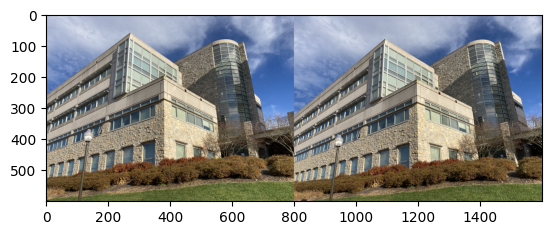

In [225]:
# Load and display a stereo image pair
#
left_img = load_image("Durham1.png")
right_img = load_image("Durham2.png")
show_image(np.concatenate([left_img, right_img], axis=1))

Now verify that you can use OpenCV tools to detect SIFT-based keypoints. The following code block should detect keypoints in one of the Durham images, and then display the image using small small circles to indicate keypoint locations.

These library functions allow for many options. For example, if you change the `nfeatures` parameter for `SIFT_create`, you'll see different numbers of detected keypoints. You may want to experiment with these parameters later.

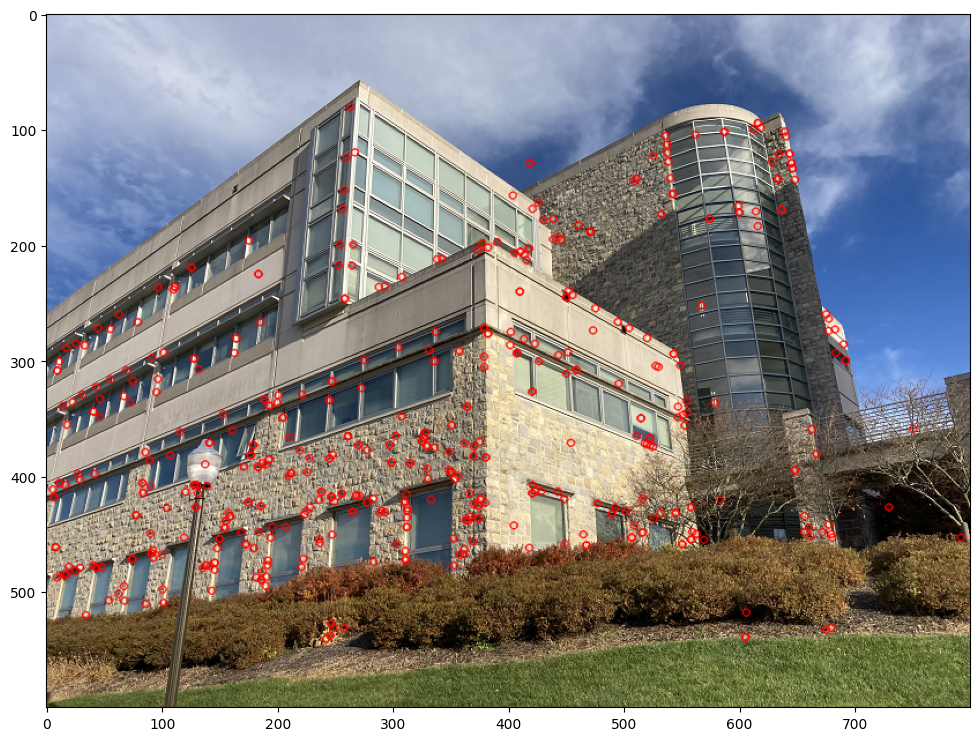

In [226]:
def testSIFT(img1):
  sift = cv2.SIFT_create(nfeatures=500)
  kp = sift.detect(img1, None)
  img1=cv2.drawKeypoints(img1, kp, None, color=(0, 0, 255))

  fig = plt.figure()
  fig.set_size_inches(12, 9) # You can adjust the size of the displayed figure
  plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))


img = cv2.imread("Durham1.png", cv2.IMREAD_COLOR)
testSIFT(img)

Next, verify that you can use a matching technique from OpenCV that tries to detect corresponding keypoints between 2 images. This example displays an example with a small number of correspondences.

The library function  `cv2.BFmatcher()` is OpenCV's "brute force" matcher. More description is given in
https://github.com/abidrahmank/OpenCV2-Python-Tutorials/blob/master/source/py_tutorials/py_feature2d/py_matcher/py_matcher.rst

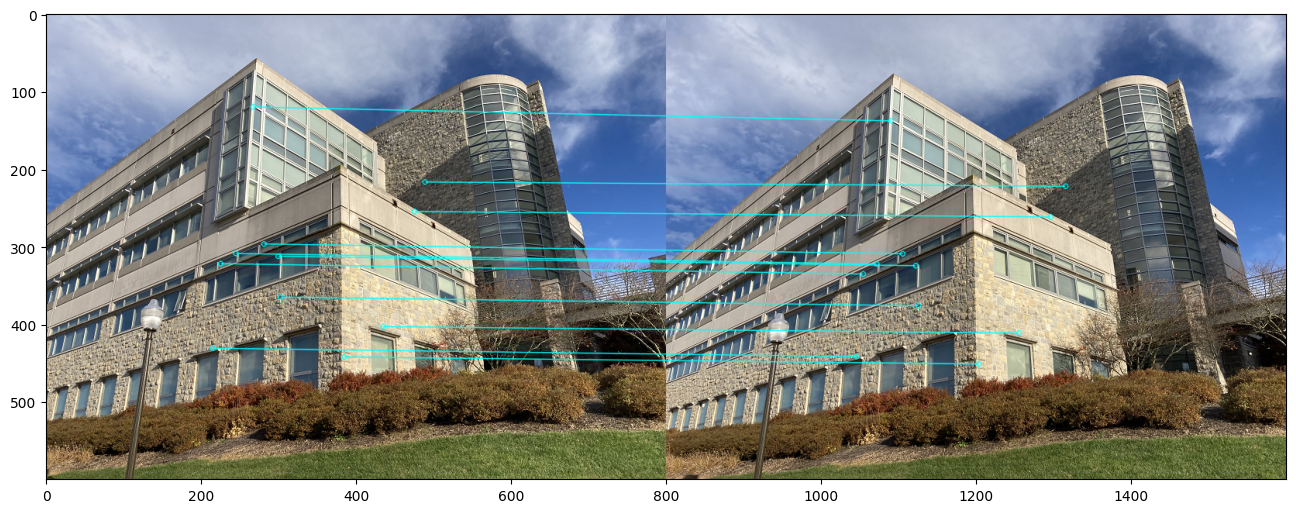

In [227]:
def genSIFTMatchPairs(img1, img2, numberOfMatches):
  # Find keypoints and their SIFT descriptors in the two images
  sift = cv2.SIFT_create()
  kp1, des1 = sift.detectAndCompute(img1, None)
  kp2, des2 = sift.detectAndCompute(img2, None)

  # Search for corresponding pairs of points
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
  matches = bf.match(des1, des2)

  # Sort them based on distance (dissimilarity) between two descriptors
  matches = sorted(matches, key = lambda x:x.distance)

  pts1 = np.zeros((numberOfMatches, 2))
  pts2 = np.zeros((numberOfMatches, 2))
  for i in range(numberOfMatches):
    pts1[i,:] = kp1[matches[i].queryIdx].pt
    pts2[i,:] = kp2[matches[i].trainIdx].pt
  return pts1, pts2, matches[:numberOfMatches], kp1, kp2

def testMatchingProcedure():
  img1 = cv2.imread('Durham1.png')
  img2 = cv2.imread('Durham2.png')

  # Perform the matching step (here, only the best 11 correspondences are returned)
  pts1, pts2, matches1to2, kp1, kp2 = genSIFTMatchPairs(img1, img2, 11)
  # Now pts1 and pts2 should contain lists of corresponding points
  #  within img1 and img2, respectively
  #  Each point has the format [column row]

  # Display the two images to check the results visually
  #  (the parameter flags=2 removes unmatched points from the display)
  matching_result = cv2.drawMatches(img1, kp1, img2, kp2, matches1to2, None, flags=2,
    matchColor = (255, 255, 0), singlePointColor=(0, 0, 255))
  fig = plt.figure()
  fig.set_size_inches(16, 10) # You can adjust the size of the displayed figure
  plt.imshow(cv2.cvtColor(matching_result, cv2.COLOR_BGR2RGB))


testMatchingProcedure()

The previous steps have shown how you can use OpenCV to find several pairs of corresponding points in two images. For this problem, you need to detect correspondences and use them to solve for the fundamental matrix *F* that relates the two images. You must demonstrate a correct result by using *F* to draw epipolar lines for keypoints that you detect.

The main parts of this problem are as follows:

*   **Part (a)** Write code that implements the **8-point algorithm to compute *F*.** For a given set of 8 or more correspondences, find a least-squares solution for *F* based on  those image points. An outline of the approach will be given in the lecture slides. You do not need to consider outliers for this problem.  
*   **Part (b)** Write a function that uses *F* to **compute the epipoles** for the two images.
*   **Part (c)** Write a function to **display two images and highlight keypoints** that have been detected in both images. Also **display epipolar lines** that you obtain using your computed *F* matrix. One or both images should show epipolar lines passing through (or near) those keypoints.
*   **Part (d)** Write a function that **combines all of the steps**, including keypoint detection and matching.

**Part (a):  8-point algorithm**
Implement the following function, as described above.



In [228]:
##############################
# TO DO: Implement the findFundamentalMatrix function
#  (You are allowed to subdivide your code into additional functions that are called by this one)
#
def findFundamentalMatrix(pts1, pts2, scale):
  '''
  Use the eight-point algorithm to compute the fundamental matrix for the given points.
  Input:
      pts1: keypoint locations for image 1, shape (N, 2), where N >= 8
      pts2: keypoint locations for image 2, with a corresponding point for every one in pts1
      scale: use this scale factor to convert all coordinates to the range [0, 1]
              (see the additional notes that have been provided for this problem)
  Returns:
      F: the fundamental matrix, shape (3, 3)
  '''
  N = pts1.shape[0]

  # Construct the normalization matrix T
  T = np.array([[1/scale, 0, 0],
                [0, 1/scale, 0],
                [0,     0,    1]])

  # Convert points to homogeneous coordinates
  pts1_h = np.hstack((pts1, np.ones((N, 1))))
  pts2_h = np.hstack((pts2, np.ones((N, 1))))

  # Normalize the points
  pts1_norm = (T @ pts1_h.T).T
  pts2_norm = (T @ pts2_h.T).T

  # Construct matrix A using the normalized points
  A = np.zeros((N, 9))
  for i in range(N):
      x1, y1, _ = pts1_norm[i]
      x2, y2, _ = pts2_norm[i]
      A[i] = [x1 * x2, y1 * x2, x2,
              x1 * y2, y1 * y2, y2,
              x1,      y1,      1]

  # Solve for F using SVD
  U, S, Vt = np.linalg.svd(A)
  F = Vt[-1].reshape(3, 3)

  # Enforce rank-2 constraint on F by zeroing the smallest singular value
  U, S, Vt = np.linalg.svd(F)
  S[2] = 0  # Set the smallest singular value to zero
  F_rank2 = U @ np.diag(S) @ Vt

  # Denormalize F
  F = T.T @ F_rank2 @ T

  return F


**Part (b): Epipoles**

Write a function that uses *F* to compute the epipoles for the
two images.

In [229]:
##############################
# TO DO: Implement the findEpipoles function
#
def findEpipoles(F):
  '''Compute the two epipoles from a given fundamental matrix
   Input:
    F: fundamental (or essential) matrix, shape (3, 3)
   Returns:
    e1, e2: the two epipoles; each is a vector with 3 components
  '''
  # The following 2 lines are just placeholders. Replace them with your code.
  U, S, Vt = np.linalg.svd(F)
  e1 = Vt[-1]  # The last column of V corresponds to the null space
  e1 /= e1[2]  # Normalize so that the last component is 1

  # Compute the right epipole (null space of F^T)
  U, S, Vt = np.linalg.svd(F.T)
  e2 = Vt[-1]  # The last column of V corresponds to the null space
  e2 /= e2[2]  # Normalize so that the last component is 1

  return e1, e2


For grading purposes, run the following code block to print your computed matrix *F*
and the two epipoles for the sample points that are given below.

In [230]:
##############################
# Do not modify this code block
#  (For debugging, you could copy this code to another block and edit it there)

# The following are some matching keypoints that were detected in the Durham1 and Durham2 images.
pts1_list = [
  [224.95256042, 321.64755249],
  [280.72879028, 296.15835571],
  [302.34194946, 364.82437134],
  [434.68283081, 402.86990356],
  [244.64321899, 308.50286865],
  [488.62979126, 216.26953125],
  [214.77470398, 430.75869751],
  [299.20846558, 312.07217407],
  [266.94125366, 119.36679077],
  [384.41549683, 442.05865479],
  [475.28448486, 254.28138733]]

pts2_list = [
  [253.88285828, 335.00772095],
  [304.884552,   308.89205933],
  [325.33914185, 375.91308594],
  [455.15515137, 411.18075562],
  [271.48794556, 322.07028198],
  [515.11816406, 221.74610901],
  [245.31390381, 441.54830933],
  [321.74771118, 324.31417847],
  [289.86627197, 137.46456909],
  [403.3711853,  451.08905029],
  [496.16610718, 261.36074829]]

pts1 = np.asarray(pts1_list)
pts2 = np.asarray(pts2_list)

# Compute F and the epipoles;
#  scale factor 800 is the largest (row, column) size of the Durham images
F = findFundamentalMatrix(pts1, pts2, 800)
e1, e2 = findEpipoles(F)

# Print F and the epipoles
print('F =\n', F)
print('\n')
print('normalized epipole #1:', e1/e1[2])
print('normalized epipole #2:', e2/e2[2])


F =
 [[ 1.40042276e-09  5.47813205e-07 -3.05356607e-04]
 [-4.27566912e-07  9.92883549e-09 -7.75993616e-04]
 [ 2.43313203e-04  7.04216837e-04  4.26336765e-02]]


normalized epipole #1: [-1.80185470e+03  5.62016328e+02  1.00000000e+00]
normalized epipole #2: [-1.29574249e+03  5.64820637e+02  1.00000000e+00]


**Part (c): Epipolar lines**

Write a function `displayEpipolarLines` that will display two stereo images and highlight keypoints in both images. Also display epipolar lines in at least one of the images. This function should display information for all of the keypoints that are provided to it. For practical reasons, usually it is best to display a small number of keypoints (e.g., 15 or 20, not 200) so that it is relatively easy to see the individual keypoints and lines.



In [231]:
def draw_epipolar_lines(img, lines, pts):
    '''Draws epipolar lines and keypoints on the image.'''
    r, c, _ = img.shape
    img_copy = img.copy()

    # Use random colors for each line
    colors = [tuple(np.random.randint(0, 255, 3).tolist()) for _ in range(len(lines))]

    for line, pt, color in zip(lines, pts, colors):
        # Normalize the line to prevent numerical instability
        a, b, c = line
        x0, y0 = 0, int(-c / b) if b != 0 else 0
        x1, y1 = img.shape[1], int(-(c + a * img.shape[1]) / b) if b != 0 else 0

        # Draw the line and the keypoint
        img_copy = cv2.line(img_copy, (x0, y0), (x1, y1), color, 1)
        img_copy = cv2.circle(img_copy, (int(pt[0]), int(pt[1])), 5, color, -1)

    return img_copy

def displayEpipolarLines(pts1, pts2, F, img1, img2):
    '''Display two images with highlighted keypoints and epipolar lines.'''
    # Convert points to homogeneous coordinates
    pts1_homog = np.hstack((pts1, np.ones((pts1.shape[0], 1))))
    pts2_homog = np.hstack((pts2, np.ones((pts2.shape[0], 1))))

    # Compute the epipolar lines for the points in both images
    lines1 = (F @ pts2_homog.T).T  # Epipolar lines in img1 for points in img2
    lines2 = (F.T @ pts1_homog.T).T  # Epipolar lines in img2 for points in img1

    # Normalize the lines for numerical stability
    lines1 /= np.linalg.norm(lines1[:, :2], axis=1)[:, np.newaxis]
    lines2 /= np.linalg.norm(lines2[:, :2], axis=1)[:, np.newaxis]

    # Draw lines and points on both images
    img1_with_lines = draw_epipolar_lines(img1, lines1, pts1)
    img2_with_lines = draw_epipolar_lines(img2, lines2, pts2)

    # Display the images side by side
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    axes[0].imshow(cv2.cvtColor(img1_with_lines, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Image 1 with Epipolar Lines")
    axes[0].axis('off')

    axes[1].imshow(cv2.cvtColor(img2_with_lines, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Image 2 with Epipolar Lines")
    axes[1].axis('off')

    plt.show()

Run the following code block to test your code. This test uses a precomputed set of 11 correspondences from the Durham images. (Here I'm using 11 correspondences because my least-squared results were much worse with a smaller number. Possible reasons: not well distributed spatially across the images, or lens distortion, etc.)

Fmat =
 [[ 1.40042276e-09  5.47813205e-07 -3.05356607e-04]
 [-4.27566912e-07  9.92883549e-09 -7.75993616e-04]
 [ 2.43313203e-04  7.04216837e-04  4.26336765e-02]]


normalized epipole #1: [-1.80185470e+03  5.62016328e+02  1.00000000e+00]
normalized epipole #2: [-1.29574249e+03  5.64820637e+02  1.00000000e+00]


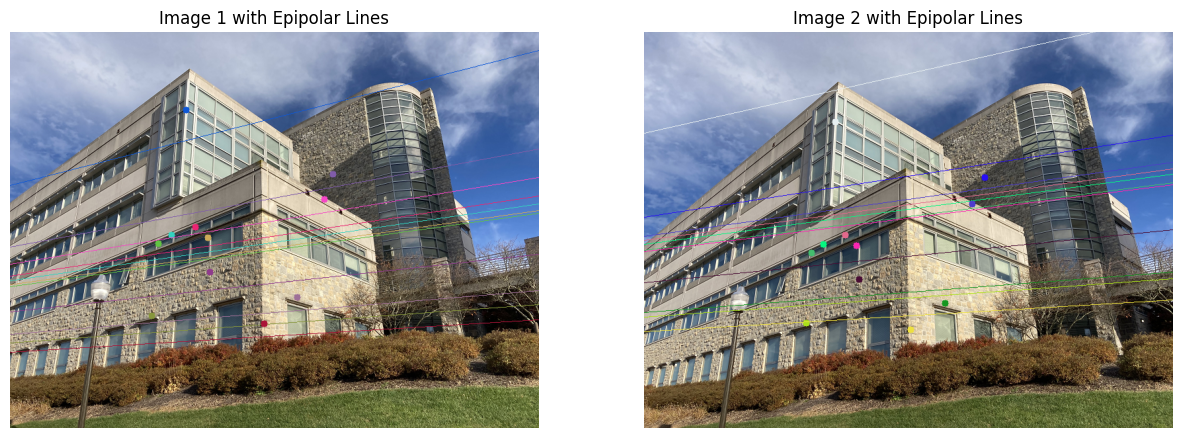

In [232]:
##############################
# Do not modify this code block
#  (For debugging, you could copy this code to another block and edit it there)
#
def testEpipolarLines():
  img1 = cv2.imread('Durham1.png')
  img2 = cv2.imread('Durham2.png')

  # The following are some matching keypoints that were detected in the Durham1 and Durham2 images.
  pts1_list = [
    [224.95256042, 321.64755249],
    [280.72879028, 296.15835571],
    [302.34194946, 364.82437134],
    [434.68283081, 402.86990356],
    [244.64321899, 308.50286865],
    [488.62979126, 216.26953125],
    [214.77470398, 430.75869751],
    [299.20846558, 312.07217407],
    [266.94125366, 119.36679077],
    [384.41549683, 442.05865479],
    [475.28448486, 254.28138733]]

  pts2_list = [
    [253.88285828, 335.00772095],
    [304.884552,   308.89205933],
    [325.33914185, 375.91308594],
    [455.15515137, 411.18075562],
    [271.48794556, 322.07028198],
    [515.11816406, 221.74610901],
    [245.31390381, 441.54830933],
    [321.74771118, 324.31417847],
    [289.86627197, 137.46456909],
    [403.3711853,  451.08905029],
    [496.16610718, 261.36074829]]

  pts1 = np.asarray(pts1_list)
  pts2 = np.asarray(pts2_list)

  # Compute F and the epipoles
  #  Scale factor 800 is the largest (row, column) size of the Durham images
  Fmat = findFundamentalMatrix(pts1, pts2, 800)
  e1tmp, e2tmp = findEpipoles(Fmat)

  # Print F and the epipoles
  print('Fmat =\n', Fmat)
  print('\n')
  print('normalized epipole #1:', e1tmp/e1tmp[2])
  print('normalized epipole #2:', e2tmp/e2tmp[2])

  # Display the two images with epipolar lines highlighted
  displayEpipolarLines(pts1, pts2, Fmat, img1, img2)


testEpipolarLines()


**Part (d): Full sequence**

Write a function that performs the full sequence of operations: load two images, detect SIFT keypoints, perform stereo matching, compute the fundamental matrix, and display the results.

Show your results using the files `statue1.png` and `statue2.png`.
For all steps up to performing stereo matching, you may borrow liberally from the "starter code" in this notebook, although you may need to adjust some of the parameters in order to get good results. To compute the fundamental matrix, you must call your function `findFundamentalMatrix`. To display the results, you must call your function `displayEpipolarLines`.


In [233]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_image(filename):
    '''Loads an image from the specified file.'''
    image = cv2.imread(filename)
    if image is None:
        raise FileNotFoundError(f"Image file '{filename}' not found.")
    return image

def stereoMatchingAndDisplay(img1file, img2file):
    '''Perform the full sequence of operations: detect keypoints, match,
       compute the fundamental matrix, and display epipolar lines.'''
    # Step 1: Load images
    img1 = load_image(img1file)
    img2 = load_image(img2file)

    # Step 2: Detect SIFT keypoints and match them
    pts1, pts2, matches, kp1, kp2 = genSIFTMatchPairs(img1, img2, numberOfMatches=50)

    # Step 3: Compute the fundamental matrix using the 8-point algorithm
    scale = max(img1.shape[0], img1.shape[1])
    F = findFundamentalMatrix(pts1, pts2, scale)

    # Step 4: Display epipolar lines using the computed fundamental matrix
    displayEpipolarLines(pts1, pts2, F, img1, img2)



Run the following code block to test your  `stereoMatchingAndDisplay` function.

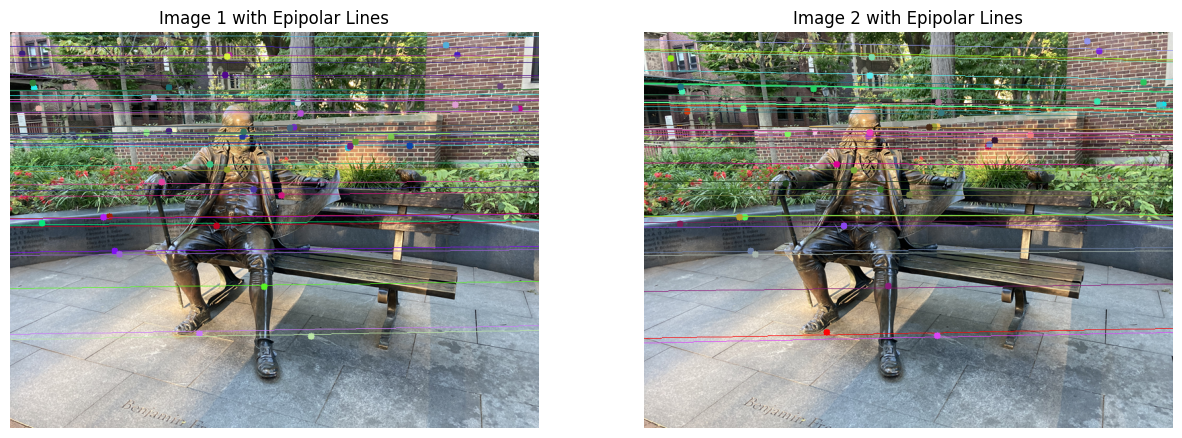

In [234]:
##############################
# Do not change the first line of code in this block, for the "statue" image pair.
#  It is okay (but not required) to add more lines that test your stereoMatchingAndDisplay
#  function with additional stereo pairs.
#
stereoMatchingAndDisplay('statue1.png', 'statue2.png')



# **Problem 6: Using RANSAC to deal with outliers**

*For ECE 5554 students, this problem is required. For ECE 4554 students, this problem is optional and will count as extra credit.*

In the previous problem, undoubtedly you saw that incorrect correspondences can be reported by the OpenCV tools. It is likely that those false matches will act as outliers in your estimation of the fundamental matrix.

As discussed during lectures, the RANSAC algorithm is a popular way to deal with outliers during model fitting. Here you must implement the RANSAC approach to compute the fundamental matrix *F*.

A suggestion is that you detect *N*>20 correspondences from an image pair, and repeatly call your `findFundamentalMatrix` function with only 8 correspondences that are drawn at random. Based on the computed *F*, determine which correspondences are inliers, and refine your estimate of *F* using all of the inliers.

*Note that this problem is more open-ended than previous coding problems.* You need to make choices about what parameters to use, what input images to process, and what results to report. Use comments and print statements (as described below) to tell the grader what you have done. Be sure  to provide clear explanations to the grader.


In [235]:
##############################
# TO DO: Implement the following function
#  (You are allowed to subdivide your code into additional functions that are called by this one)
#
def calculate_sampson_distance(pts1_homog, pts2_homog, F):
    '''Calculates the Sampson distance for each pair of points.'''
    # Compute the numerator: (x2^T * F * x1)^2
    Fx1 = F @ pts1_homog.T  # Shape: (3, N)
    Ftx2 = F.T @ pts2_homog.T  # Shape: (3, N)
    numerator = (np.sum(pts2_homog * (F @ pts1_homog.T).T, axis=1))**2

    # Compute the denominator: (F * x1)_1^2 + (F * x1)_2^2 + (F^T * x2)_1^2 + (F^T * x2)_2^2
    denominator = (Fx1[0, :])**2 + (Fx1[1, :])**2 + (Ftx2[0, :])**2 + (Ftx2[1, :])**2

    # Avoid division by zero
    denominator = np.where(denominator < 1e-8, 1e-8, denominator)

    # Compute the Sampson distance
    distance = numerator / denominator
    return distance

def findFundamentalMatrixUsingRansac(pts1, pts2, scale, max_iterations=100, threshold=0.01):
    '''Use the eight-point algorithm and RANSAC to compute the fundamental matrix while handling outliers.'''
    num_points = pts1.shape[0]
    best_inlier_count = 0
    best_F = None
    best_inliers = None

    # Normalize the points
    pts1_normalized = pts1 #/ scale
    pts2_normalized = pts2 #/ scale

    for _ in range(max_iterations):
        # Randomly select 8 correspondences
        indices = np.random.choice(num_points, 8, replace=False)
        sample_pts1 = pts1_normalized[indices]
        sample_pts2 = pts2_normalized[indices]

        # Compute the fundamental matrix using the 8-point algorithm
        F = findFundamentalMatrix(sample_pts1, sample_pts2, scale)

        # Calculate the Sampson distance for all points
        ones = np.ones((num_points, 1))
        pts1_homog = np.hstack((pts1_normalized, ones))
        pts2_homog = np.hstack((pts2_normalized, ones))
        distances = calculate_sampson_distance(pts1_homog, pts2_homog, F)

        # Identify inliers based on the threshold
        inliers = distances < threshold
        inlier_count = np.sum(inliers)

        # Update the best model if the current one has more inliers
        if inlier_count > best_inlier_count:
            best_inlier_count = inlier_count
            best_F = F
            best_inliers = inliers

    return best_F, best_inliers


In the following code block, write code to test the RANSAC method that you have implemented in `findFundamentalMatrixUsingRansac`. Try to select an image pair and algorithm parameters for which RANSAC gives a good improvement over the non-RANSAC 8-point algorithm. Generate and display outputs for both cases, as a  comparison of your results *with* RANSAC and your results *without* RANSAC. Use print statements liberally to explain to the grader the different outputs that you have generated.  As part of your code's comments, describe how you decide which correspondences are outliers. (If convenient, you may also provide additional descriptions in a text block below.)

In [236]:
def testRansacImplementation(img1file, img2file):
    # Load images and detect keypoints
    img1 = load_image(img1file)
    img2 = load_image(img2file)
    pts1, pts2, matches, kp1, kp2 = genSIFTMatchPairs(img1, img2, numberOfMatches=100)

    # Compute F using the non-RANSAC 8-point algorithm
    scale = max(img1.shape[0], img1.shape[1])
    F_non_ransac = findFundamentalMatrix(pts1, pts2, scale)
    print("\n--- Fundamental Matrix Estimation Without RANSAC ---")
    print("Fundamental Matrix (without RANSAC):\n", F_non_ransac)
    print("Note: This matrix is computed using all correspondences, including potential outliers.\n")

    # Compute F using the RANSAC approach
    F_ransac, inliers = findFundamentalMatrixUsingRansac(pts1, pts2, scale)
    print("\n--- Fundamental Matrix Estimation With RANSAC ---")
    print("Fundamental Matrix (with RANSAC):\n", F_ransac)
    print(f"Number of inliers: {np.sum(inliers)} out of {len(pts1)}")
    print("Note: This matrix is computed using only inliers identified by RANSAC.")
    print("      The RANSAC algorithm filters out outliers by using the Sampson distance as a loss function.\n")

    # Explain the choice of Sampson distance
    print("--- Explanation of the Sampson Distance ---")
    print("The Sampson distance is chosen as a loss function because it provides a more accurate measure of")
    print("how well each point correspondence fits the estimated fundamental matrix.")
    print("It accounts for the epipolar line geometry, reducing the impact of outliers on our estimation.\n")

    # Explain the RANSAC parameters
    print("--- RANSAC Parameters ---")
    print("Max Iterations: 100")
    print("Reason: 100 iterations provide a good balance between computational efficiency and the probability")
    print("        of finding a robust model that excludes outliers.")
    print("Threshold: 0.01")
    print("Reason: A threshold of 0.01 was found to effectively distinguish inliers from outliers without")
    print("        being too lenient or too strict.\n")

    # Visualize the results
    print("--- Comparison of Results ---")
    print("The epipolar lines computed using the fundamental matrix with RANSAC should align better with")
    print("the corresponding points in both images, demonstrating the effectiveness of RANSAC in handling outliers.")
    print("Without RANSAC, the epipolar lines may not align well, indicating the influence of outliers.\n")

    # Display epipolar lines without RANSAC
    print("--- Visualizing Epipolar Lines Without RANSAC ---")
    displayEpipolarLines(pts1, pts2, F_non_ransac, img1, img2)

    # Display epipolar lines with RANSAC
    print("--- Visualizing Epipolar Lines With RANSAC ---")
    displayEpipolarLines(pts1[inliers], pts2[inliers], F_ransac, img1, img2)

# Run the test
testRansacImplementation('statue1.png', 'statue2.png')


Output hidden; open in https://colab.research.google.com to view.

1. Choosing the Distance Metric: Sampson Distance
The Sampson distance is used because it provides a more accurate measure of how well a point correspondence fits the estimated fundamental matrix compared to simpler metrics like the algebraic distance.
It takes into account the geometry of the epipolar lines and measures how far a point is from its corresponding epipolar line in both images.
Why It’s Important: Using a more reliable distance measure ensures that we more accurately identify true inliers and filter out false matches (outliers).
2. How We Calculate the Sampson Distance:
We calculate the Sampson distance for every correspondence   are the homogeneous coordinates of the points in the first and second images, respectively.
F is the fundamental matrix.
The numerator measures the squared distance of the point from the epipolar line.
The denominator normalizes this distance, taking into account the geometry of the epipolar lines.
3. Deciding the Inlier Threshold:
We set a distance threshold of 0.01 (or another empirically chosen value) to classify correspondences as inliers or outliers.
How the Threshold Works:
If the Sampson distance for a correspondence is less than the threshold, it is considered an inlier. This means the correspondence fits the estimated fundamental matrix well.
If the distance is greater than the threshold, it is considered an outlier. This means the correspondence is likely a false match or does not adhere to the underlying epipolar geometry.
4. Why This Threshold:
The chosen threshold of 0.01 was determined through experimentation:
Smaller Thresholds: Would be too strict, possibly rejecting valid correspondences.
Larger Thresholds: Would be too lenient, allowing outliers to be classified as inliers.
The balance ensures that we have a good number of inliers while effectively excluding outliers.
5. Number of Iterations:
We use 100 iterations in RANSAC, which provides a reasonable probability of finding a good model given the presence of outliers.
Why 100 Iterations:
RANSAC is a probabilistic algorithm, and more iterations increase the chance of finding a model that is not affected by outliers.
However, more iterations also increase computation time. We chose 100 as a balance between robustness and efficiency.
Identifying Outliers
Outliers are correspondences where the Sampson distance is greater than the threshold. These are likely due to incorrect matches in the keypoint detection and matching process.
By using RANSAC, we can filter out these outliers and compute a more accurate fundamental matrix using only the inliers.
Conclusion
Without RANSAC: The fundamental matrix is estimated using all correspondences, including outliers, leading to poor alignment of epipolar lines.
With RANSAC: The fundamental matrix is computed using only the inliers, resulting in much better alignment of
epipollar lines






---
# Creating a PDF version of your current notebook

In [237]:
#The following two installation steps are needed to generate a PDF version of the notebook
#(These lines are needed within Google Colab, but are not needed within a local version of Jupyter notebook)
!apt-get -qq install texlive texlive-xetex texlive-latex-extra pandoc
!pip install --quiet pypandoc

Extracting templates from packages: 100%
Preconfiguring packages ...
Selecting previously unselected package fonts-droid-fallback.
(Reading database ... 123623 files and directories currently installed.)
Preparing to unpack .../00-fonts-droid-fallback_1%3a6.0.1r16-1.1build1_all.deb ...
Unpacking fonts-droid-fallback (1:6.0.1r16-1.1build1) ...
Selecting previously unselected package fonts-lato.
Preparing to unpack .../01-fonts-lato_2.0-2.1_all.deb ...
Unpacking fonts-lato (2.0-2.1) ...
Selecting previously unselected package poppler-data.
Preparing to unpack .../02-poppler-data_0.4.11-1_all.deb ...
Unpacking poppler-data (0.4.11-1) ...
Selecting previously unselected package tex-common.
Preparing to unpack .../03-tex-common_6.17_all.deb ...
Unpacking tex-common (6.17) ...
Selecting previously unselected package fonts-urw-base35.
Preparing to unpack .../04-fonts-urw-base35_20200910-1_all.deb ...
Unpacking fonts-urw-base35 (20200910-1) ...
Selecting previously unselected package libgs9-co

In [239]:
# TO DO: Provide the full path to your Jupyter notebook file
!jupyter nbconvert --to PDF "/content/drive/My Drive/Colab Notebooks/HW3/Homework3_ddave.ipynb"

[NbConvertApp] Converting notebook /content/drive/My Drive/Colab Notebooks/HW3/Homework3_ddave.ipynb to PDF
[NbConvertApp] Support files will be in Homework3_ddave_files/
[NbConvertApp] Making directory ./Homework3_ddave_files
[NbConvertApp] Writing 141494 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 6494252 bytes to /content/drive/My Drive/Colab Notebooks/HW3/Homework3_ddave.pdf
